# Gaussian Mixture Model Exoplanet Atmospheric Retrieval 

In [93]:
#%pip install -r requirements.txt --break-system-packages

### Import delle librerie e file ARIEL

In [94]:
import numpy as np
import pandas as pd
import os
import h5py
import random
import sys
import corner
import matplotlib.pyplot as plt
import taurex.log
import importlib
import seaborn as sns
import posterior_utils
import ast
import numpy as np
import warnings
import helper
import ast
import matplotlib.patches as mpatches

importlib.reload(helper) 
check_parameters_valid = helper.check_parameters_valid
sys.path.append(os.path.abspath('./'))
importlib.reload(posterior_utils)

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib.patches import Ellipse
from submit_format import *
from matplotlib.lines import Line2D
from sklearn.preprocessing import normalize
from sklearn.mixture import GaussianMixture
from sklearn import mixture
from helper import *
from preprocessing import *
from submit_format import to_competition_format
from posterior_utils import *
from spectral_metric import *
from FM_utils_final import *
from sklearn.preprocessing import StandardScaler
from matplotlib.lines import Line2D
from submit_format import get_unique_filename
from sklearn.exceptions import ConvergenceWarning

taurex.log.disableLogging()
np.set_printoptions(suppress=True, linewidth=np.nan, threshold=sys.maxsize)
# Filtering dei Warning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", message="more than 1 Rp value detected in the trace! Using first value")

## Setting variabili
### Utilizziamo lo StandardScaler per trasformare e scalare gli input ottenendo *media unitaria* e *varianza nulla*

In [95]:
n_repeat = 5
random_state = 40
# random_state = random.randint(1,1000)
# print(f'Random State : {random_state}')

# Lettura dati dai file 
aux = np.load('aux.npy')
spec_matrix = np.load('spectra.npy')
noise = np.load('noise.npy')
labels = np.load('label.npy')
validTraces = np.load('validTraces.npy')
num_spectra = spec_matrix.shape[0]
labels_names = ['planet_radius','planet_temp','log_H2O','log_CO2','log_CO','log_CH4','log_NH3']

# Setting dei path
training_path = './Check_Dataset/TrainingData'
training_GT_path = os.path.join(training_path, 'Ground Truth Package')
trace_GT = h5py.File(os.path.join(training_GT_path, 'TraceData.hdf5'), "r")
validTraces = validTraces.astype(np.int64)
for X in trace_GT.keys():
    tr_GT = trace_GT[X]['tracedata'][()]
    weights_GT = trace_GT[X]['weights'][()]
    if np.isnan(tr_GT).sum() == 1:
        continue
    validTraces = np.append(validTraces, int(X[12:]))
vt = validTraces
test_ind = np.sort(vt - 1)
train_ind = np.setdiff1d(np.arange(num_spectra), test_ind)
plot_ind = random.sample(range(len(test_ind)), 10)
spectra_ind = random.sample(range(len(test_ind)), 10)

#-------|Preprocessing dei dati spettrali|--------

# Preprocessamento dei test spectra
test_spectra = spec_matrix[test_ind, :]
test_spectra = augment_data(test_spectra, noise[test_ind, :], repeat=1)
test_spectra = test_spectra.reshape(-1, spec_matrix.shape[1])

# Preprocessamento dei train spectra
train_spectra = spec_matrix[train_ind, :]
train_spectra = augment_data(train_spectra, noise[train_ind, :], repeat=n_repeat)
train_spectra = train_spectra.reshape(-1, spec_matrix.shape[1])

# Dati ausiliari e labels
train_aux = aux[train_ind, :]
train_aux = np.repeat(train_aux, repeats=n_repeat, axis=0)
test_aux = aux[test_ind, :]
train_labels = labels[train_ind, :]
train_labels = np.repeat(train_labels, repeats=n_repeat, axis=0)
test_labels = labels[test_ind, :]

# Applichiamo StandardScaler per preservare meglio la distribuzione originale
scaler = StandardScaler()
train_spectra = scaler.fit_transform(train_spectra)
test_spectra = scaler.transform(test_spectra)

# Setup per gli score

In [96]:
# Liste per salvare tutti gli score
posterior_scores = []
spectral_scores = []
# Inizializziamo la bounds_matrix, ovvero la matrice delle distrubuzioni a priori delle molecole
bounds_matrix = default_prior_bounds()
beta = 0.8
q_list = np.linspace(0.01, 0.99, 10) # Lista di q per il calcolo del quantile
opacity_path = "./XSEC/"
CIA_path = "./HITRAN"
# Carichiamo i dati dello strumento simulato di ARIEL
ariel_wlgrid, ariel_wlwidth, ariel_wngrid, ariel_wnwidth = ariel_resolution()
# Inizializziamo il forward model (modello planetario)
fm = initialise_forward_model(opacity_path, CIA_path)
RJUP = 69911000
MJUP = 1.898e27
RSOL = 696340000
Rs = aux[:, 2] / RSOL
Mp = aux[:, 4] / MJUP
n_samples = 1000

# Applicazione del Clustering
- $K_1$ : numero di cluster di 1o livello
- $K_2$ : numero di 'sottocluster' (cluster di 2o livello)
- $GMM_i$ : output del Gaussian Mixture Model
- $Labels_i$ : labels ottenute dal GMM di ciascun livello
> Cerchiamo, in ogni sottocluster (K2), i cluster contenenti un singolo spettro, che sono considerati *outlier*, cioe' anomali (composti da un solo spettro)

`Si puo' usare il BIC (o l'AIC) per ottenere i migliori valori di $K_1$ e $K_2$`

In [97]:
# (19,15) risulta essere la migliore coppia
K1 = 19
K2 = 15
GMM_i = []
Labels_i = []

pl_cluster_map = {}
final_labels = [None] * len(train_aux)
subclusters = 0
K1_szs = []
K2_szs = []

# Primo clustering (1° livello) sui dati ausiliari
gmm = mixture.GaussianMixture(n_components=K1, random_state=random_state, max_iter=400).fit(train_aux)
labels_1 = gmm.predict(train_aux)
for i in range(K1):
    spectra_i = np.where(labels_1 == i)[0]
    print("Spettri nel cluster #", i, " -> ", len(spectra_i))
    # Secondo clustering (2° livello) sui dati spettrali appartenenti al cluster i
    tmp = mixture.GaussianMixture(n_components=K2, random_state=random_state).fit(train_spectra[spectra_i, :])
    labels_2 = tmp.predict(train_spectra[spectra_i, :])
    GMM_i.append(tmp)
    Labels_i.append(labels_2)
    K1_szs.append(len(spectra_i))
    for j in range(K2):
        spectra_j = np.where(labels_2 == j)[0]
        if len(spectra_j) == 1:
            print(f"\t [{i}].{j} sottocluster con singolo spettro [OUTLIER]")
            #spectra_i = np.delete(spectra_i,spectra_j) # Rimozione dell'outlier
        K2_szs.append(len(spectra_j))
        cluster_name = f"{i}.{j}"
        subclusters+=1
        for id1,id2 in zip(spectra_i, spectra_j):
            cluster_level = f'{i}.{id2}'
            final_labels[id1] = cluster_level

pl_cluster_map = {str(int(pid[0])): label for pid, label in zip(train_aux, final_labels) if label is not None}
pl_cluster_map = {f"train{key}": value for key, value in pl_cluster_map.items()}

Spettri nel cluster # 0  ->  18310
Spettri nel cluster # 1  ->  3870
Spettri nel cluster # 2  ->  330
	 [2].11 sottocluster con singolo spettro [OUTLIER]
Spettri nel cluster # 3  ->  2520
	 [3].3 sottocluster con singolo spettro [OUTLIER]
Spettri nel cluster # 4  ->  715
Spettri nel cluster # 5  ->  5220
Spettri nel cluster # 6  ->  23505
Spettri nel cluster # 7  ->  7510
Spettri nel cluster # 8  ->  26870
Spettri nel cluster # 9  ->  14085
Spettri nel cluster # 10  ->  3905
Spettri nel cluster # 11  ->  8725
Spettri nel cluster # 12  ->  12680
Spettri nel cluster # 13  ->  6830
Spettri nel cluster # 14  ->  19785
Spettri nel cluster # 15  ->  14845
Spettri nel cluster # 16  ->  1860
Spettri nel cluster # 17  ->  1335
Spettri nel cluster # 18  ->  385
	 [18].4 sottocluster con singolo spettro [OUTLIER]


## Plotting Istogrammi

<Figure size 600x500 with 0 Axes>

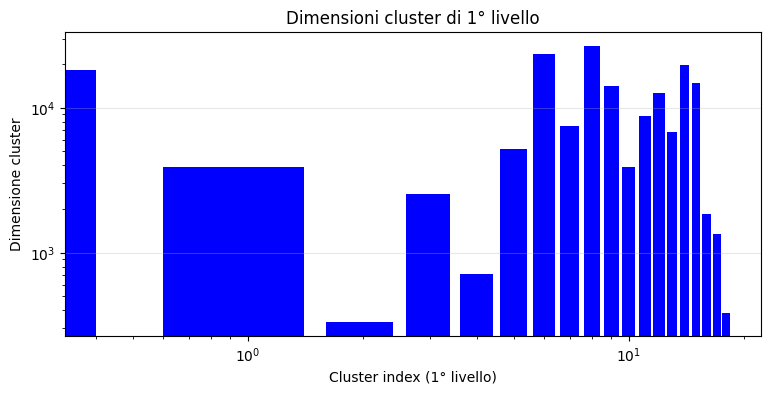

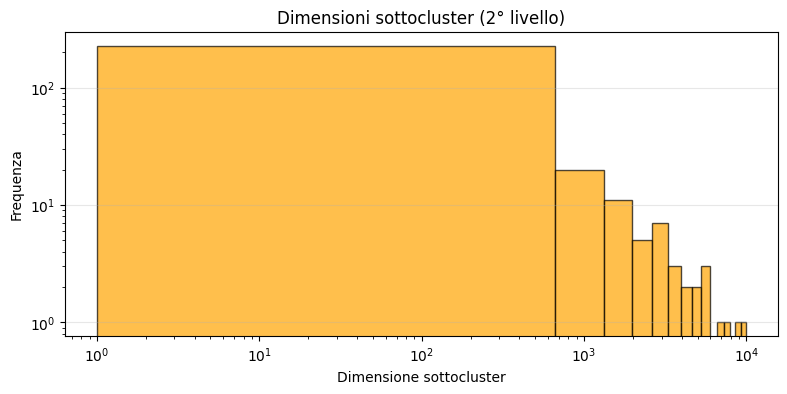

In [98]:
fig = plt.figure(figsize=(6, 5))
labs = ['1° livello', '2° livello']
vals = [K1, K2]

# Bar chart - 1° livello (19 cluster)
plt.figure(figsize=(8,4))
plt.bar(range(len(K1_szs)), K1_szs, color='blue')
plt.title('Dimensioni cluster di 1° livello')
plt.xlabel('Cluster index (1° livello)')
plt.ylabel('Dimensione cluster')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.xscale('log')
plt.yscale('log')
hist_name2 = get_unique_filename('Clusters_dims_log','.png','Clusters/')
plt.savefig(hist_name2)
plt.show()

# Istogramma - 2° livello (19*15 = 285 sottocluster)
plt.figure(figsize=(8,4))
plt.hist(K2_szs, bins=15, color='orange', alpha=0.7, edgecolor='black')
plt.title('Dimensioni sottocluster (2° livello)')
plt.xlabel('Dimensione sottocluster')
plt.ylabel('Frequenza')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.xscale('log')
plt.yscale('log')
hist_name3 = get_unique_filename('Subclusters_dims_log','.png','Clusters/')
plt.savefig(hist_name3)
plt.show()

## Calcolo degli score

In [99]:
# Liste per salvare tutti gli score
posterior_scores = []
spectral_scores = []
# Inizializziamo la bounds_matrix, ovvero la matrice delle distrubuzioni a priori delle molecole
bounds_matrix = default_prior_bounds()
beta = 0.8
q_list = np.linspace(0.01, 0.99, 10) # Lista di q per il calcolo del quantile
opacity_path = "./XSEC/"
CIA_path = "./HITRAN"
# Carichiamo i dati dello strumento simulato di ARIEL
ariel_wlgrid, ariel_wlwidth, ariel_wngrid, ariel_wnwidth = ariel_resolution()
# Inizializziamo il forward model (modello planetario)
fm = initialise_forward_model(opacity_path, CIA_path)
RJUP = 69911000
MJUP = 1.898e27
RSOL = 696340000
Rs = aux[:, 2] / RSOL
Mp = aux[:, 4] / MJUP
# Calcoliamo lo score solo su una parte dei sample (fino a 2*spec_max)
spec_max = 30
n_spec = 0
spec_ind = random.sample(range(len(test_ind)),spec_max*2)
'''
# Liste per salvare i parametri usati e gli score ottenuti
k1_vals = []
k2_vals = []
posterior_scores_k = []
spectral_scores_k = []
scores_k = []
'''
pl_inds = []
all_w = []
all_p = []
for X in range(len(test_ind)):
	# Fitting sui dati ausiliari
	idx1 = gmm.predict(test_aux[X, :].reshape(1, -1))[0]
	km = GMM_i[idx1] 
	labels_2 = Labels_i[idx1]
	# Fitting sui dati spettrali
	idx2 = km.predict(test_spectra[X, :].reshape(1, -1))[0]
	idx_1 = np.where(labels_1 == idx1)[0]
	idx_2 = np.where(labels_2 == idx2)[0]
	cluster_membs = idx_1[labels_2==idx2] # Indici dei membri del cluster
	# Estraiamo i membri del cluster
	lab = train_labels[cluster_membs,:]
	lab = lab.reshape(-1,lab.shape[-1])
	posterior = lab
	all_p.append(posterior)
	# Calcoliamo il peso di ogni membro del cluster
	weights1 = np.ones((posterior.shape[0],1)) / posterior.shape[0] # Pesi statici unitari
	all_w.append(weights1)
	planet_index = test_ind[X]+1
	pl_inds.append(f'train{planet_index}')
	# Carichiamo i dati del ground truth
	tr_GT = trace_GT[f'Planet_train{planet_index}']['tracedata'][()]
	wh_GT = trace_GT[f'Planet_train{planet_index}']['weights'][()]
	# Controllo se ci sono nan -> se ci sono, non calcoliamo lo score
	if np.isnan(tr_GT).sum() >= 1:
		print("nan trovato")
		exit()
	score = compute_posterior_loss(posterior, weights1, tr_GT, wh_GT,bounds_matrix)
	posterior_scores.append(score)
	if n_spec<spec_max and X in spec_ind:
		try:
			proxy_compute_spectrum = setup_dedicated_fm(fm, test_ind[X], Rs, Mp, ariel_wngrid, ariel_wnwidth )
			sscore = compute_spectral_loss(posterior, weights1, tr_GT, wh_GT, bounds_matrix, proxy_compute_spectrum, q_list)
			spectral_scores.append(sscore)
			print('*****Spectral: ',sscore)
			print('*****Posterior: ',score)
			n_spec+=1
		except RuntimeWarning:
			continue

/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:109: RuntimeWarning: invalid value encountered in sqrt
  k[0] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:113: RuntimeWarning: invalid value encountered in sqrt
  k[1:] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:118: RuntimeWarning: invalid value encountered in sqrt
  k[1:] -= np.sqrt(


*****Spectral:  534.7217010205998
*****Posterior:  379.2044347891228


/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:109: RuntimeWarning: invalid value encountered in sqrt
  k[0] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:113: RuntimeWarning: invalid value encountered in sqrt
  k[1:] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:118: RuntimeWarning: invalid value encountered in sqrt
  k[1:] -= np.sqrt(


*****Spectral:  965.092140836218
*****Posterior:  487.0291400142146


/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:109: RuntimeWarning: invalid value encountered in sqrt
  k[0] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:113: RuntimeWarning: invalid value encountered in sqrt
  k[1:] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:118: RuntimeWarning: invalid value encountered in sqrt
  k[1:] -= np.sqrt(


*****Spectral:  689.3306421617515
*****Posterior:  376.60875160875156


/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:109: RuntimeWarning: invalid value encountered in sqrt
  k[0] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:113: RuntimeWarning: invalid value encountered in sqrt
  k[1:] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:118: RuntimeWarning: invalid value encountered in sqrt
  k[1:] -= np.sqrt(


*****Spectral:  676.2267393902797
*****Posterior:  184.52380952380955


/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:109: RuntimeWarning: invalid value encountered in sqrt
  k[0] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:113: RuntimeWarning: invalid value encountered in sqrt
  k[1:] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:118: RuntimeWarning: invalid value encountered in sqrt
  k[1:] -= np.sqrt(


*****Spectral:  725.3453833298454
*****Posterior:  410.11279208530624


/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:109: RuntimeWarning: invalid value encountered in sqrt
  k[0] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:113: RuntimeWarning: invalid value encountered in sqrt
  k[1:] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:118: RuntimeWarning: invalid value encountered in sqrt
  k[1:] -= np.sqrt(


*****Spectral:  753.5001147185209
*****Posterior:  387.2660885440438


/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:109: RuntimeWarning: invalid value encountered in sqrt
  k[0] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:113: RuntimeWarning: invalid value encountered in sqrt
  k[1:] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:118: RuntimeWarning: invalid value encountered in sqrt
  k[1:] -= np.sqrt(


*****Spectral:  701.4605611421147
*****Posterior:  376.7904163893631


/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:109: RuntimeWarning: invalid value encountered in sqrt
  k[0] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:113: RuntimeWarning: invalid value encountered in sqrt
  k[1:] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:118: RuntimeWarning: invalid value encountered in sqrt
  k[1:] -= np.sqrt(


*****Spectral:  246.4000310375759
*****Posterior:  363.95389451624163


/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:109: RuntimeWarning: invalid value encountered in sqrt
  k[0] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:113: RuntimeWarning: invalid value encountered in sqrt
  k[1:] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:118: RuntimeWarning: invalid value encountered in sqrt
  k[1:] -= np.sqrt(


*****Spectral:  961.8736724992228
*****Posterior:  490.4939587775408


/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:109: RuntimeWarning: invalid value encountered in sqrt
  k[0] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:113: RuntimeWarning: invalid value encountered in sqrt
  k[1:] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:118: RuntimeWarning: invalid value encountered in sqrt
  k[1:] -= np.sqrt(


*****Spectral:  760.0918674095135
*****Posterior:  361.6886440636654


/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:109: RuntimeWarning: invalid value encountered in sqrt
  k[0] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:113: RuntimeWarning: invalid value encountered in sqrt
  k[1:] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:118: RuntimeWarning: invalid value encountered in sqrt
  k[1:] -= np.sqrt(


*****Spectral:  725.5278277740733
*****Posterior:  312.91181830926683


/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:109: RuntimeWarning: invalid value encountered in sqrt
  k[0] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:113: RuntimeWarning: invalid value encountered in sqrt
  k[1:] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:118: RuntimeWarning: invalid value encountered in sqrt
  k[1:] -= np.sqrt(


*****Spectral:  700.1143057326191
*****Posterior:  346.9543701331781


/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:109: RuntimeWarning: invalid value encountered in sqrt
  k[0] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:113: RuntimeWarning: invalid value encountered in sqrt
  k[1:] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:118: RuntimeWarning: invalid value encountered in sqrt
  k[1:] -= np.sqrt(


*****Spectral:  455.4903476025753
*****Posterior:  360.0


/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:109: RuntimeWarning: invalid value encountered in sqrt
  k[0] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:113: RuntimeWarning: invalid value encountered in sqrt
  k[1:] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:118: RuntimeWarning: invalid value encountered in sqrt
  k[1:] -= np.sqrt(


*****Spectral:  639.7881214052135
*****Posterior:  368.4838838042181


/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:109: RuntimeWarning: invalid value encountered in sqrt
  k[0] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:113: RuntimeWarning: invalid value encountered in sqrt
  k[1:] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:118: RuntimeWarning: invalid value encountered in sqrt
  k[1:] -= np.sqrt(


*****Spectral:  638.292487261108
*****Posterior:  271.1864406779661


/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:109: RuntimeWarning: invalid value encountered in sqrt
  k[0] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:113: RuntimeWarning: invalid value encountered in sqrt
  k[1:] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:118: RuntimeWarning: invalid value encountered in sqrt
  k[1:] -= np.sqrt(


*****Spectral:  732.137181346138
*****Posterior:  317.497886728656


/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:109: RuntimeWarning: invalid value encountered in sqrt
  k[0] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:113: RuntimeWarning: invalid value encountered in sqrt
  k[1:] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:118: RuntimeWarning: invalid value encountered in sqrt
  k[1:] -= np.sqrt(


*****Spectral:  855.5245389649489
*****Posterior:  335.3401061917304


/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:109: RuntimeWarning: invalid value encountered in sqrt
  k[0] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:113: RuntimeWarning: invalid value encountered in sqrt
  k[1:] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:118: RuntimeWarning: invalid value encountered in sqrt
  k[1:] -= np.sqrt(


*****Spectral:  876.539206894469
*****Posterior:  335.33984263911276


/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:109: RuntimeWarning: invalid value encountered in sqrt
  k[0] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:113: RuntimeWarning: invalid value encountered in sqrt
  k[1:] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:118: RuntimeWarning: invalid value encountered in sqrt
  k[1:] -= np.sqrt(


*****Spectral:  716.8397010863014
*****Posterior:  442.9936494747463


/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:109: RuntimeWarning: invalid value encountered in sqrt
  k[0] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:113: RuntimeWarning: invalid value encountered in sqrt
  k[1:] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:118: RuntimeWarning: invalid value encountered in sqrt
  k[1:] -= np.sqrt(


*****Spectral:  826.2343874252103
*****Posterior:  434.011400792847


/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:109: RuntimeWarning: invalid value encountered in sqrt
  k[0] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:113: RuntimeWarning: invalid value encountered in sqrt
  k[1:] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:118: RuntimeWarning: invalid value encountered in sqrt
  k[1:] -= np.sqrt(


*****Spectral:  805.5249183314065
*****Posterior:  371.2920759499842


/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:109: RuntimeWarning: invalid value encountered in sqrt
  k[0] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:113: RuntimeWarning: invalid value encountered in sqrt
  k[1:] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:118: RuntimeWarning: invalid value encountered in sqrt
  k[1:] -= np.sqrt(


*****Spectral:  701.7369775289292
*****Posterior:  392.82383764820815


/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:109: RuntimeWarning: invalid value encountered in sqrt
  k[0] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:113: RuntimeWarning: invalid value encountered in sqrt
  k[1:] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:118: RuntimeWarning: invalid value encountered in sqrt
  k[1:] -= np.sqrt(


*****Spectral:  612.0173204290767
*****Posterior:  342.7407622926971


/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:109: RuntimeWarning: invalid value encountered in sqrt
  k[0] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:113: RuntimeWarning: invalid value encountered in sqrt
  k[1:] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:118: RuntimeWarning: invalid value encountered in sqrt
  k[1:] -= np.sqrt(


*****Spectral:  741.2370857303172
*****Posterior:  473.4490135488472


/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:109: RuntimeWarning: invalid value encountered in sqrt
  k[0] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:113: RuntimeWarning: invalid value encountered in sqrt
  k[1:] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:118: RuntimeWarning: invalid value encountered in sqrt
  k[1:] -= np.sqrt(


*****Spectral:  488.67527420158063
*****Posterior:  352.6855944265488


/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:109: RuntimeWarning: invalid value encountered in sqrt
  k[0] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:113: RuntimeWarning: invalid value encountered in sqrt
  k[1:] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:118: RuntimeWarning: invalid value encountered in sqrt
  k[1:] -= np.sqrt(


*****Spectral:  723.8058114708313
*****Posterior:  468.2769883247618


/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:109: RuntimeWarning: invalid value encountered in sqrt
  k[0] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:113: RuntimeWarning: invalid value encountered in sqrt
  k[1:] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:118: RuntimeWarning: invalid value encountered in sqrt
  k[1:] -= np.sqrt(


*****Spectral:  801.4209266128299
*****Posterior:  407.67110702802023


/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:109: RuntimeWarning: invalid value encountered in sqrt
  k[0] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:113: RuntimeWarning: invalid value encountered in sqrt
  k[1:] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:118: RuntimeWarning: invalid value encountered in sqrt
  k[1:] -= np.sqrt(


*****Spectral:  754.1889677790571
*****Posterior:  416.04326273095984


/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:109: RuntimeWarning: invalid value encountered in sqrt
  k[0] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:113: RuntimeWarning: invalid value encountered in sqrt
  k[1:] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:118: RuntimeWarning: invalid value encountered in sqrt
  k[1:] -= np.sqrt(


*****Spectral:  673.3116156189474
*****Posterior:  367.84915308405243


/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:109: RuntimeWarning: invalid value encountered in sqrt
  k[0] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:113: RuntimeWarning: invalid value encountered in sqrt
  k[1:] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:118: RuntimeWarning: invalid value encountered in sqrt
  k[1:] -= np.sqrt(


*****Spectral:  520.4796247142904
*****Posterior:  422.9155742003146


# Calcolo degli score medi
- Posterior Score : 80%
- Spectral Score : 20%
- Final score = Score finale per la Leaderboard
> final_score = 0.8 * posterior_score + 0.2 * spectral_score

In [100]:
avg_posterior_score = np.mean(posterior_scores)
print(f'Posterior_Score: {avg_posterior_score}')
avg_spectral_score = np.mean(spectral_scores)
print(f'Spectral_Score: {avg_spectral_score}')
final_score = (1 - beta) * avg_spectral_score + beta * avg_posterior_score # beta = 0.8 -> (1-beta) = 0.2
print(f"final score: {final_score:.4f}")    
'''
# Salvataggio risultati
k1_vals.append(K1)
k2_vals.append(K2)
posterior_scores_k.append(avg_posterior_score)
spectral_scores_k.append(avg_spectral_score)
scores_k.append(final_score)
with open("results.txt", "a") as f:
    f.write("\n------------------------------\n")
    f.write("K1: {}\n".format(k1_vals))
    f.write("K2: {}\n".format(k2_vals))
    f.write("Posterior scores: {}\n".format(posterior_scores_k))
    f.write("Spectral scores: {}\n".format(spectral_scores_k))
    f.write("Final scores: {}\n".format(scores_k))
f.close()
'''

Posterior_Score: 371.1097360418644
Spectral_Score: 700.0976493818523
final score: 436.9073


'\n# Salvataggio risultati\nk1_vals.append(K1)\nk2_vals.append(K2)\nposterior_scores_k.append(avg_posterior_score)\nspectral_scores_k.append(avg_spectral_score)\nscores_k.append(final_score)\nwith open("results.txt", "a") as f:\n    f.write("\n------------------------------\n")\n    f.write("K1: {}\n".format(k1_vals))\n    f.write("K2: {}\n".format(k2_vals))\n    f.write("Posterior scores: {}\n".format(posterior_scores_k))\n    f.write("Spectral scores: {}\n".format(spectral_scores_k))\n    f.write("Final scores: {}\n".format(scores_k))\nf.close()\n'

## Plotting grafico Score/Clustering

In [101]:
'''
score_plot_ind = 0
# Leggi l'intero contenuto del file di testo
with open("results.txt", "r") as f:
    content = f.read()
# Suddividi in blocchi
blocks = [block for block in content.split('------------------------------') if block.strip()]
# Liste per accumulare i dati di TUTTE le iterazioni
k1_values = []
k2_values = []
posterior_vals = []
spectral_vals = []
final_vals = []
# Funzione per fare il parsing di un valore in modo sicuro
def safe_literal_eval(value):
    try:
        value = value.strip().lower()
        if value == "nan":
            return np.nan
        return ast.literal_eval(value)
    except (SyntaxError, ValueError):
        print(f"Errore nel parsing: {value}")
        return None
# Parsing di tutti i blocchi
for block in blocks:
    k1, k2 = None, None
    posterior = spectral = final = None
    lines = [line.strip() for line in block.strip().splitlines() if line.strip()]
    for line in lines:
        if line.startswith("K1:"):
            k1 = safe_literal_eval(line.split(":", 1)[1].strip())
        elif line.startswith("K2:"):
            k2 = safe_literal_eval(line.split(":", 1)[1].strip())
        elif line.startswith("Posterior"):
            posterior = safe_literal_eval(line.split(":", 1)[1].strip())
        elif line.startswith("Spectral"):
            spectral = safe_literal_eval(line.split(":", 1)[1].strip())
        elif line.startswith("Final"):
            final = safe_literal_eval(line.split(":", 1)[1].strip())
    # Se tutti i valori sono validi, registra una riga
    if all(v is not None for v in [k1, k2, posterior, spectral, final]):
        k1_values.append(k1)
        k2_values.append(k2)
        # Se posterior/spectral/final sono array/list, fai la media
        posterior_vals.append(np.mean(posterior) if isinstance(posterior, (list, tuple, np.ndarray)) else posterior)
        spectral_vals.append(np.mean(spectral) if isinstance(spectral, (list, tuple, np.ndarray)) else spectral)
        final_vals.append(np.mean(final) if isinstance(final, (list, tuple, np.ndarray)) else final)
        if len(spectral_vals) < 500: 
            continue
k_pairs = [f"({k1},{k2})" for k1, k2 in zip(k1_values, k2_values)]
valid_pairs = [i for i,k2v in enumerate(k2_values)if k2v != 1]
valid_k1 = [k1_values[i] for i in valid_pairs]
valid_k2 = [k2_values[i] for i in valid_pairs]
k_pairs = [f"({k1},{k2})" for k1, k2 in zip(valid_k1, valid_k2)]
# Plot con coppie (K1,K2)
plt.figure(figsize=(12, 6))
x_pos = np.arange(len(k_pairs))
plt.plot(x_pos, posterior_vals, marker='o', color='red', label='Posterior Score', linestyle='--')
plt.plot(x_pos, spectral_vals, marker='x', color='black', label='Spectral Score', linestyle='-.')
plt.plot(x_pos, final_vals, marker='*', color='blue', label='Final Score', linestyle=':')
plt.xticks(x_pos, k_pairs, rotation=45, ha='right', fontsize=8)
plt.xlabel('(K1, K2)', fontweight='bold')
plt.ylabel('Scores', fontweight='bold')
plt.title('Confronto Scores per Configurazioni (K1,K2)', pad=20)
plt.legend()
plt.grid(True, alpha=0.3)
# Plot dei punti
for i, (p, s, f) in enumerate(zip(posterior_vals, spectral_vals, final_vals)):
    plt.annotate(f'{p:.1f}', (x_pos[i], p), textcoords="offset points", xytext=(0,5), ha='center', color='red', fontsize=8)
    plt.annotate(f'{s:.1f}', (x_pos[i], s), textcoords="offset points", xytext=(0,5), ha='center', color='black', fontsize=8)
    plt.annotate(f'{f:.1f}', (x_pos[i], f), textcoords="offset points", xytext=(0,5), ha='center', color='blue', fontsize=8)
plt.tight_layout()
plot_fname = get_unique_filename('Grafico','.png','./Cluster_Scores/')
plt.savefig(plot_fname)
plt.show()

# Scrittura su CSV dei risultati
#df_results = pd.DataFrame({
#    'K1': k1_values,
#    'K2': k2_values,
#    'PosteriorScore': posterior_vals,
#    'SpectralScore': spectral_vals,
#    'FinalScore': final_vals
#})
# Salva su CSsdwdV
#df_results.to_csv('results.csv', index=False)
'''

'\nscore_plot_ind = 0\n# Leggi l\'intero contenuto del file di testo\nwith open("results.txt", "r") as f:\n    content = f.read()\n# Suddividi in blocchi\nblocks = [block for block in content.split(\'------------------------------\') if block.strip()]\n# Liste per accumulare i dati di TUTTE le iterazioni\nk1_values = []\nk2_values = []\nposterior_vals = []\nspectral_vals = []\nfinal_vals = []\n# Funzione per fare il parsing di un valore in modo sicuro\ndef safe_literal_eval(value):\n    try:\n        value = value.strip().lower()\n        if value == "nan":\n            return np.nan\n        return ast.literal_eval(value)\n    except (SyntaxError, ValueError):\n        print(f"Errore nel parsing: {value}")\n        return None\n# Parsing di tutti i blocchi\nfor block in blocks:\n    k1, k2 = None, None\n    posterior = spectral = final = None\n    lines = [line.strip() for line in block.strip().splitlines() if line.strip()]\n    for line in lines:\n        if line.startswith("K1:"):\n

## Function per plot di singole curve

In [102]:
def crea_plot_score(k1_prima_curva, k1_seconda_curva, df, score_type='FinalScore'):
    """
    Plotta un singolo score (score_type) per due valori di K1 in funzione di K2.
    
    Parametri:
      - k1_prima_curva: primo valore di K1
      - k1_seconda_curva: secondo valore di K1
      - df: DataFrame contenente le colonne ['K1','K2','PosteriorScore','SpectralScore','FinalScore']
      - score_type: stringa con il nome dello score da plottare ('FinalScore','SpectralScore','PosteriorScore')
    """
    # Filtra e ordina i dati per i due valori di K1
    subset1 = df[df['K1'] == k1_prima_curva].sort_values(by='K2')
    subset2 = df[df['K1'] == k1_seconda_curva].sort_values(by='K2')
    if subset1.empty and subset2.empty:
        print(f"Nessun dato disponibile per K1={k1_prima_curva} o K1={k1_seconda_curva}")
        return
    plt.figure(figsize=(8,6))
    # Plot per il primo K1
    if not subset1.empty:
        plt.plot(subset1['K2'], subset1[score_type],marker='o', label=f'K1={k1_prima_curva}', color='red')
    # Plot per il secondo K1
    if not subset2.empty:
        plt.plot(subset2['K2'], subset2[score_type],marker='o', label=f'K1={k1_seconda_curva}', color='blue')
    k2_union = sorted(set(subset1['K2']).union(subset2['K2']))
    plt.xticks(k2_union)
    plt.xlabel('K2')
    plt.ylabel(score_type)
    plt.title(f'Andamento {score_type} per K1={k1_prima_curva} vs K1={k1_seconda_curva}')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(True)
    y_min, y_max = plt.ylim()
    margine = (y_max - y_min) * 0.3
    plt.ylim(y_min - margine, y_max + margine)
    plot_fname = get_unique_filename(f'Plot_{score_type}_{k1_prima_curva}-{k1_seconda_curva}', '.png',directory='./Grafici_Clustering')
    plt.savefig(plot_fname)
    plt.show()

# Grafico andamento clustering
### Fissato K1, il grafico indica l'andamento del final_score per il variare di K2

/var/folders/fl/bx5jfr0d24bcsm06cdps7zq00000gs/T/ipykernel_5792/410444106.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap('tab10', len(k1_values)+2)


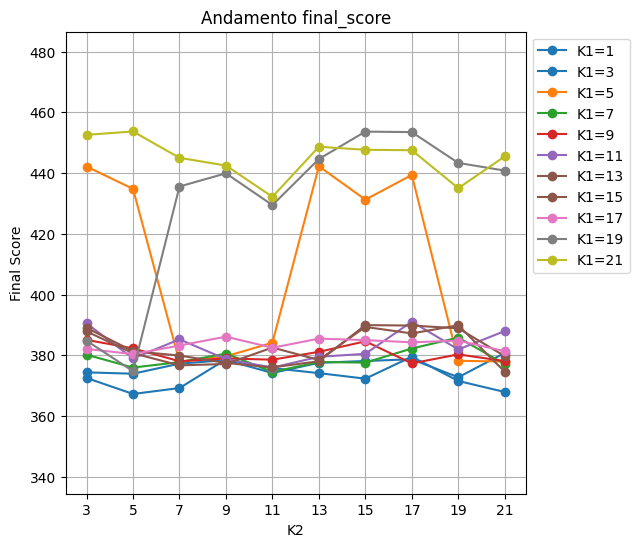

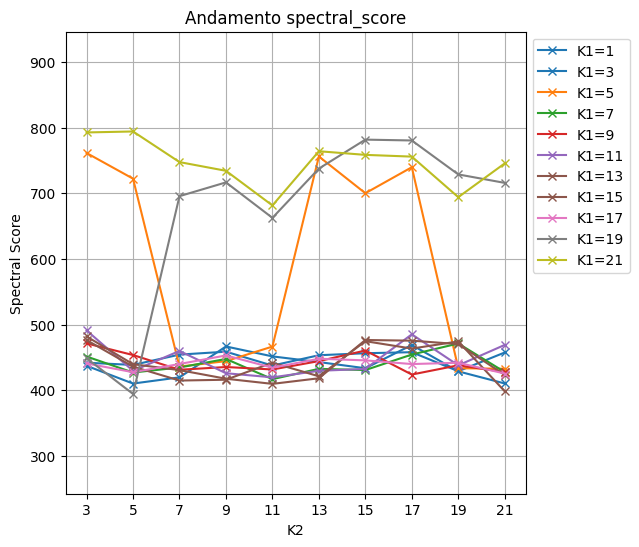

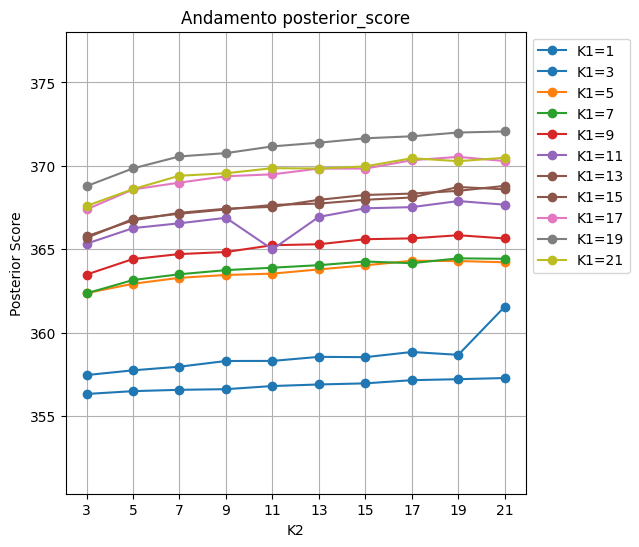

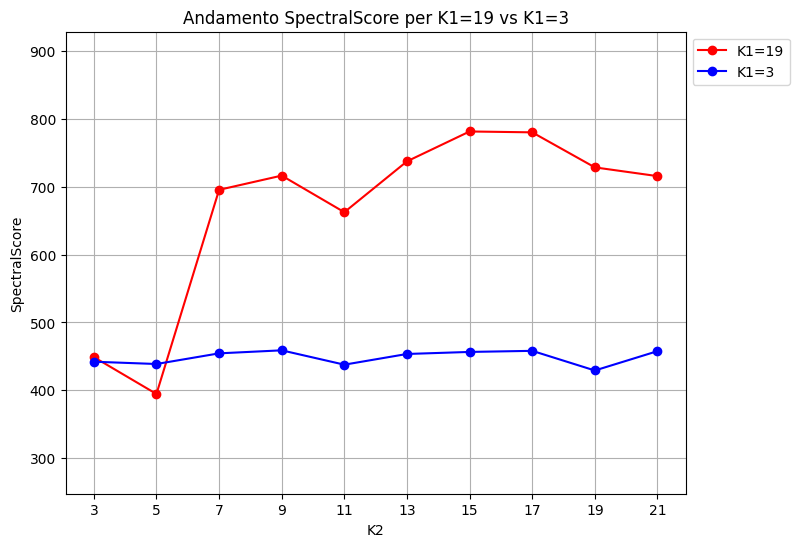

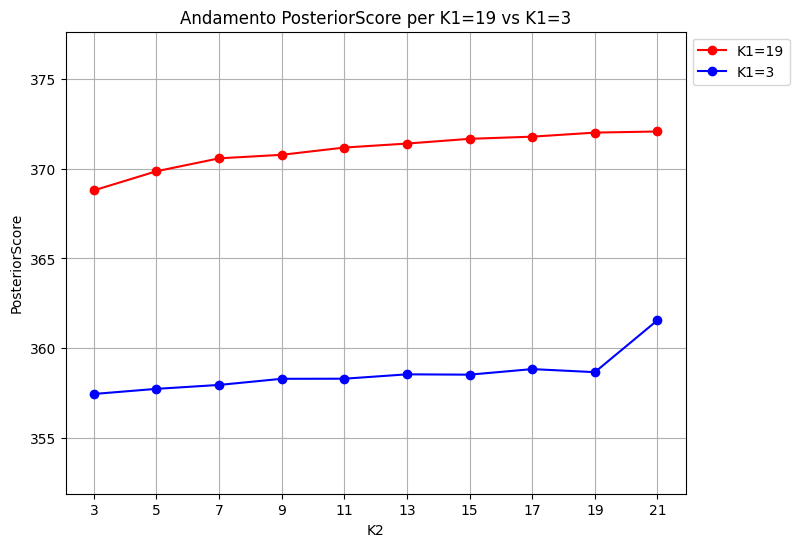

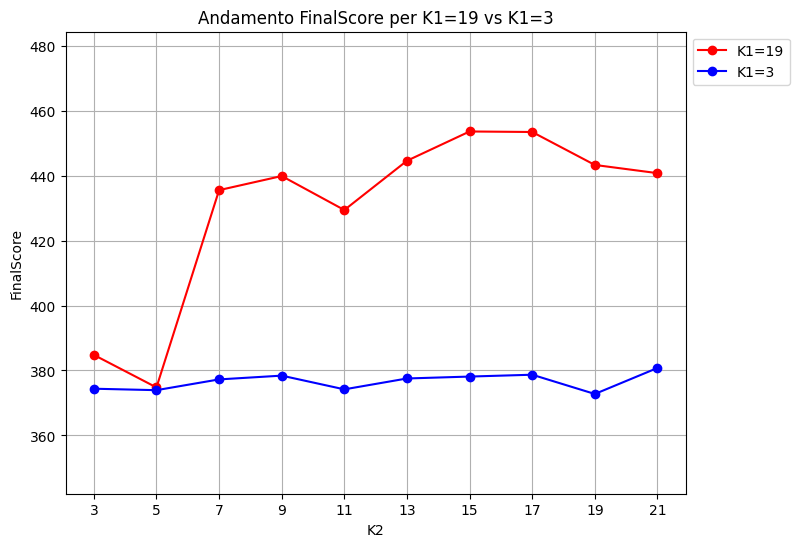

In [103]:
#------------|PLOT FINAL SCORE|------------#
df = pd.read_csv('results.csv')
# Rinomina delle colonne (se necessario)
df.columns = ['K1', 'K2', 'PosteriorScore', 'SpectralScore', 'FinalScore']
#-----Rimuovi le parentesi quadre e converti K1 e K2 in interi
df['K1'] = df['K1'].str.replace(r'[\[\]]', '', regex=True).astype(int)
df['K2'] = df['K2'].str.replace(r'[\[\]]', '', regex=True).astype(int)
#-----Filtraggio cluster a singolo sottocluster
df = df[df['K2'] != 1]  # esclude le righe dove K2 è 1
# Ordina il dataframe per K1 e K2
df = df.sort_values(by=['K1', 'K2'])
k1_values = sorted(df['K1'].unique())
unique_k2 = sorted(df['K2'].unique())
colormap = plt.cm.get_cmap('tab10', len(k1_values)+2)
plt.figure(figsize=(8,6))
for i, k1 in enumerate(k1_values):
    subset = df[df['K1'] == k1].sort_values(by='K2')
    plt.plot(subset['K2'], subset['FinalScore'], marker='o', label=f'K1={k1}', color=colormap(i))
plt.xticks(unique_k2)
plt.xlabel('K2')
plt.ylabel('Final Score')
plt.title('Andamento final_score')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.subplots_adjust(right=0.7)
plt.grid(True)
y_min, y_max = plt.ylim()  # prendi i limiti correnti
margine = (y_max - y_min) * 0.3  # aggiunge un margine del 30%
plt.ylim(y_min - margine, y_max + margine)
final_fname = get_unique_filename(f'Grafico_Final_{K1}-{K2}', '.png', directory='./Grafici_Clustering')
plt.savefig(final_fname)
plt.show()
#------------|PLOT SPECTRAL SCORE|------------#
plt.figure(figsize=(8,6))
for i, k1 in enumerate(k1_values):
    subset = df[df['K1'] == k1].sort_values(by='K2')
    plt.plot(subset['K2'], subset['SpectralScore'], marker='x', label=f'K1={k1}', color=colormap(i))
plt.xticks(unique_k2)
plt.xlabel('K2')
plt.ylabel('Spectral Score')
plt.title('Andamento spectral_score')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.subplots_adjust(right=0.7)
plt.grid(True)
y_min, y_max = plt.ylim()  # prendi i limiti correnti
margine = (y_max - y_min) * 0.3  # aggiunge un margine del 30%
plt.ylim(y_min - margine, y_max + margine)
spec_fname = get_unique_filename(f'Grafico_Spectral_{K1}-{K2}', '.png', directory='./Grafici_Clustering')
plt.savefig(spec_fname)
plt.show()
#------------|PLOT POSTERIOR SCORE|------------#
plt.figure(figsize=(8,6))
for i, k1 in enumerate(k1_values):
    subset = df[df['K1'] == k1].sort_values(by='K2')
    plt.plot(subset['K2'], subset['PosteriorScore'], marker='o', label=f'K1={k1}', color=colormap(i))
plt.xticks(unique_k2)
plt.xlabel('K2')
plt.ylabel('Posterior Score')
plt.title('Andamento posterior_score')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.subplots_adjust(right=0.7)
plt.grid(True)
y_min, y_max = plt.ylim()  # prendi i limiti correnti
margine = (y_max - y_min) * 0.3  # aggiunge un margine del 30%
plt.ylim(y_min - margine, y_max + margine)
base_fname = f'Grafico_Posterior_{K1}-{K2}'
post_fname = get_unique_filename(base_name=base_fname, extension='.png', directory='./Grafici_Clustering')
plt.savefig(post_fname)
plt.show()
#-------------------------------
# Plotting di sole due curve (K1,K2) per confronto sullo score
crea_plot_score(19,3,df,'SpectralScore')
crea_plot_score(19,3,df,'PosteriorScore')
crea_plot_score(19,3,df,'FinalScore')

# Plotting delle distribuzioni
### Si utiliza 'corner' per il plot delle distribuzioni bayesiane a posteriori

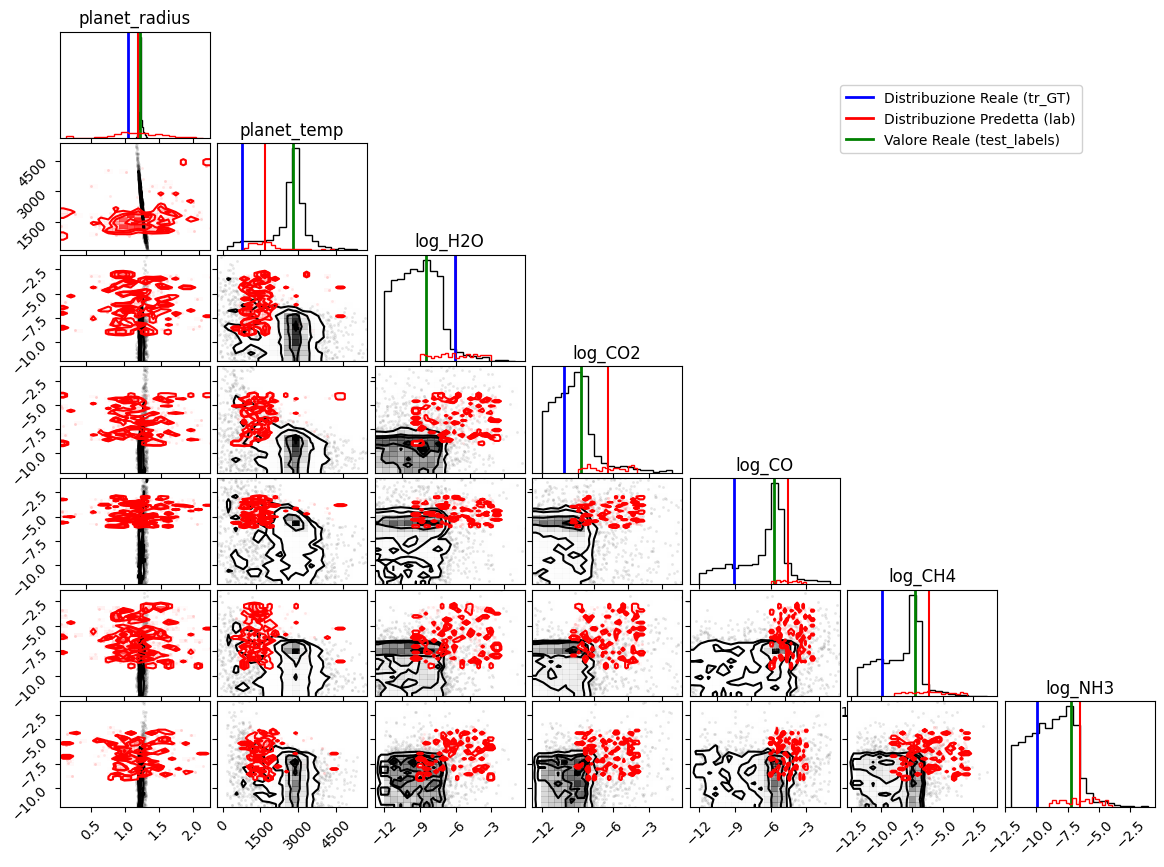

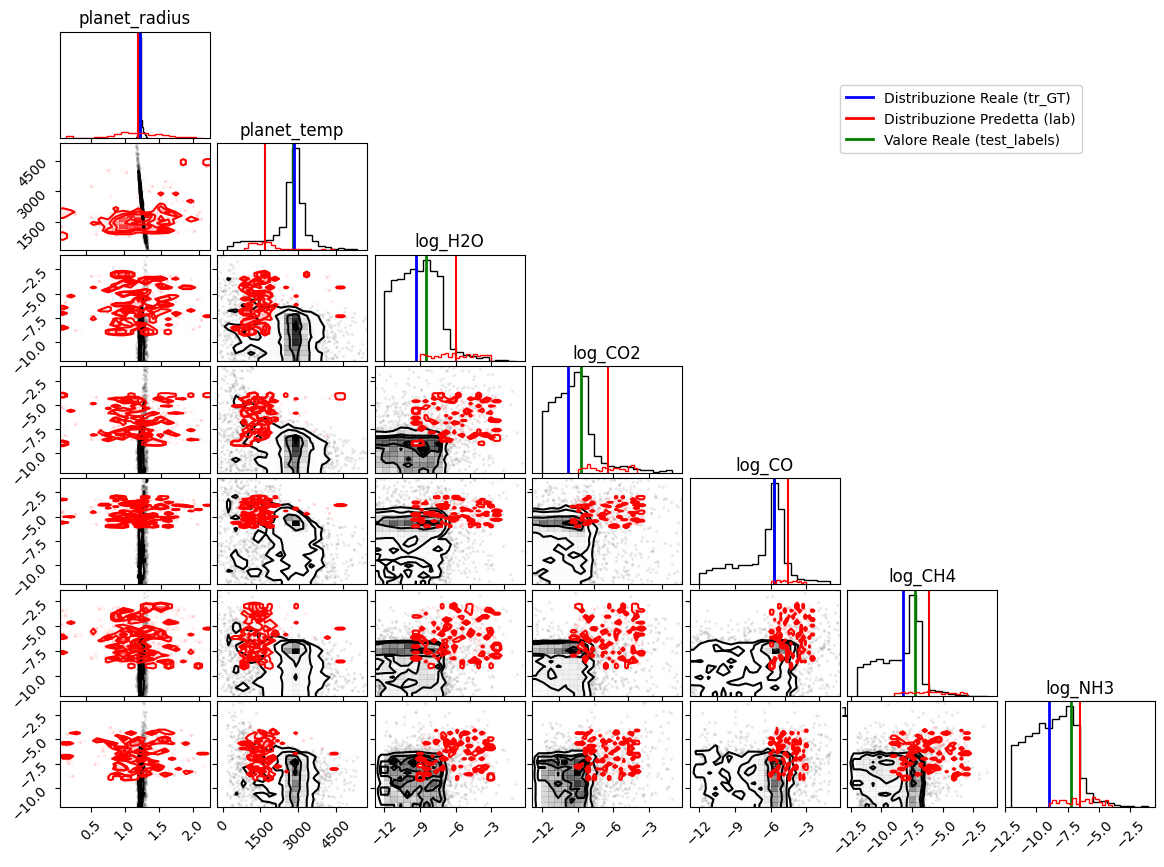

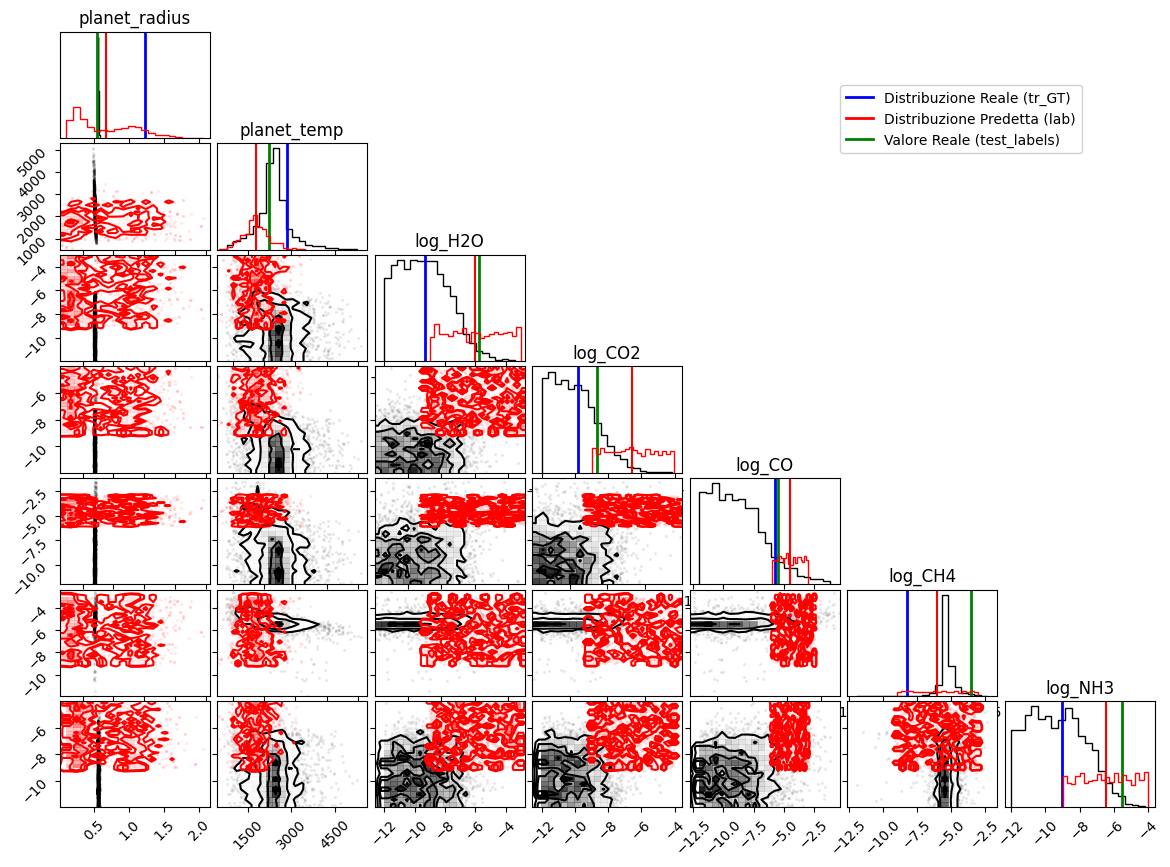

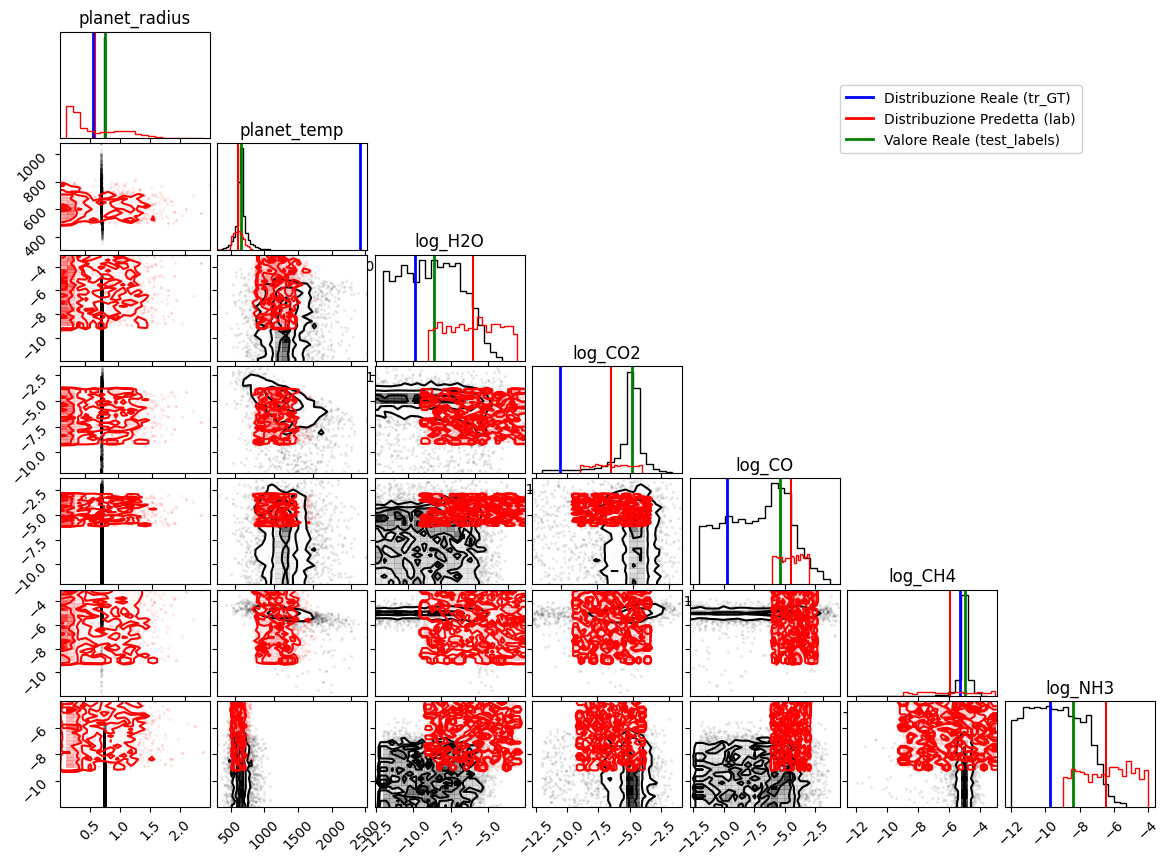

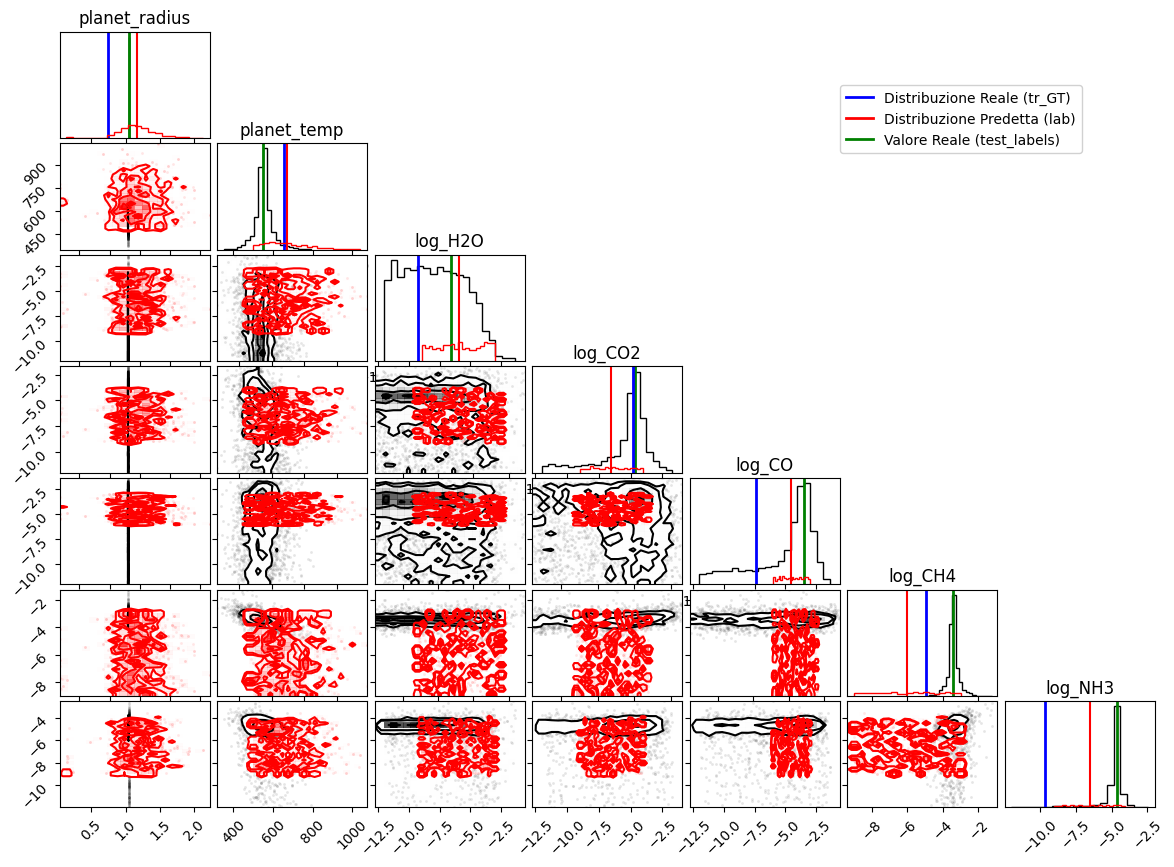

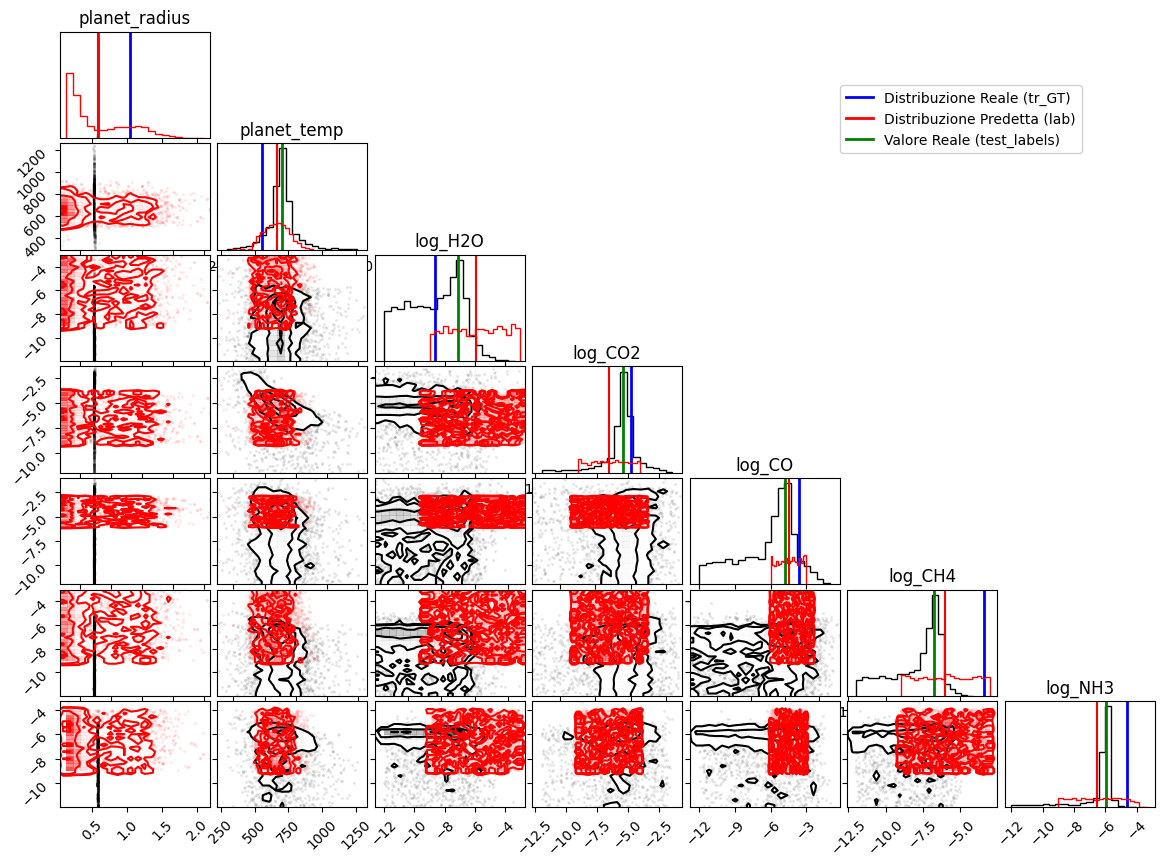

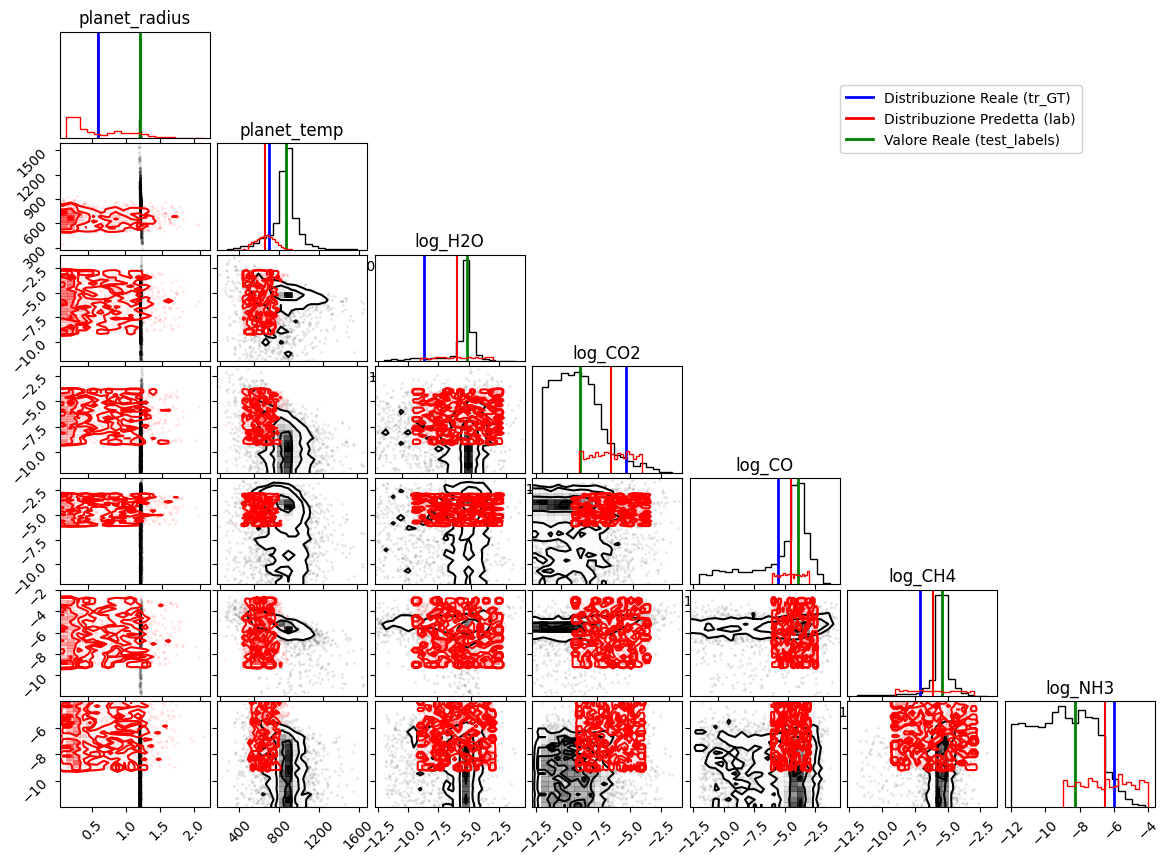

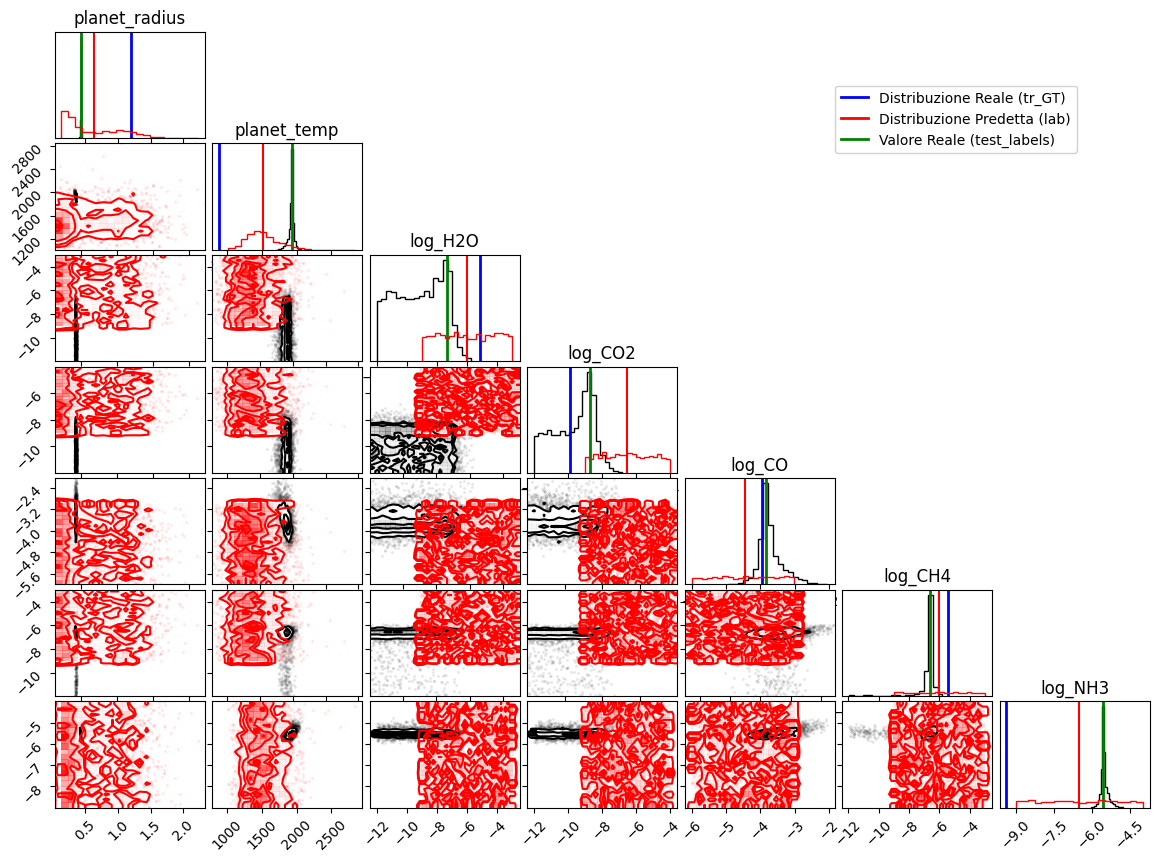

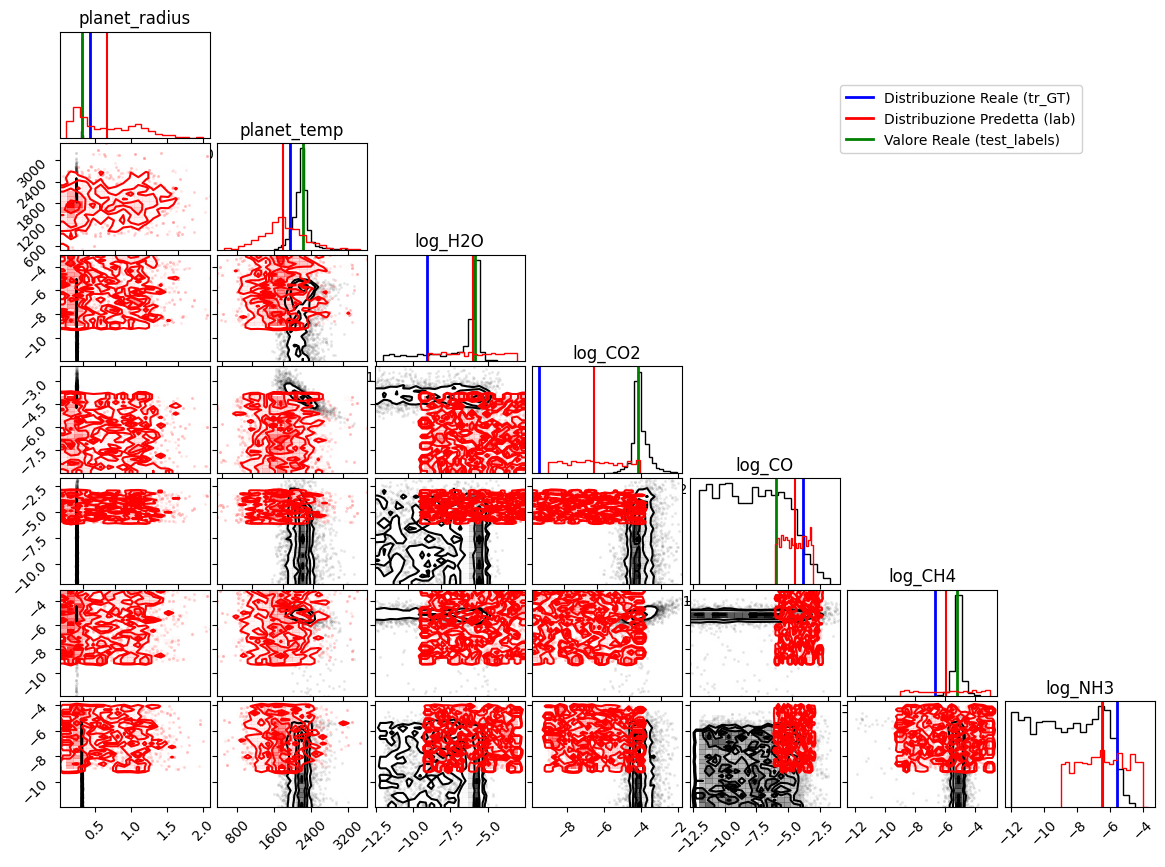

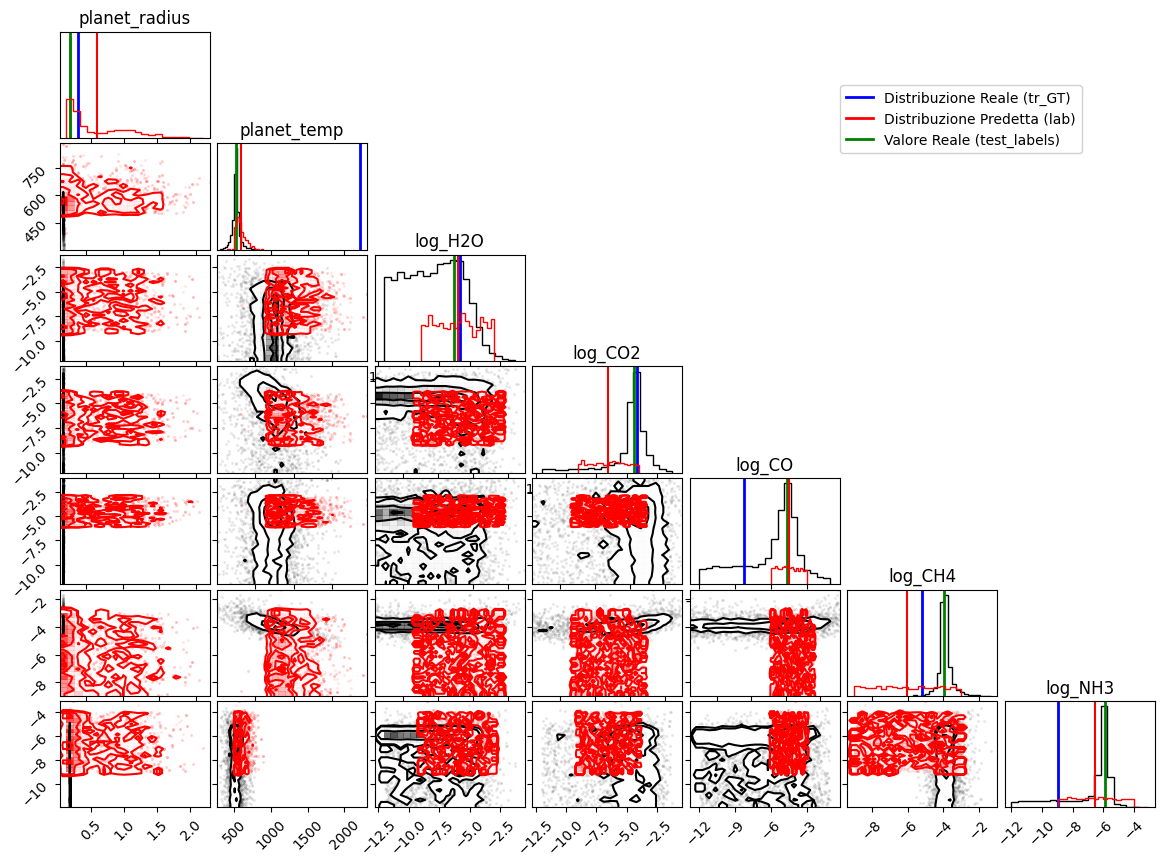

In [104]:
# Plottiamo le distribuzioni dei `plot_ind` spettri
for X in plot_ind:
	# Predizione sui dati ausiliari di test (1o livello)
	idx1 = gmm.predict(test_aux[X,:].reshape(1,-1))[0]
	km = GMM_i[idx1] # Selezione etichette
	labels_2 = Labels_i[idx1] 
	# Predizione sui dati spettrali di test (2o livello)
	idx2 = km.predict(test_spectra[X,:].reshape(1,-1))[0]
	idx_1 = np.where(labels_1 == idx1)[0] # Individuazione indici nel cluster
	idx_2 = np.where(labels_2 == idx2)[0] # Individuazione indici nel cluster
	lab = train_labels[idx_1[idx_2],:] 
	mean_lab = np.mean(lab,axis=0) # Media delle predizioni per il plot
	mean_GT = np.average(tr_GT,axis=0,weights=wh_GT) # Valore medio pesato dei dati reali
	# Lettura dati Ground Truth
	tr_GT = trace_GT[f'Planet_train{test_ind[X]+1}']['tracedata'][()]
	wh_GT = trace_GT[f'Planet_train{test_ind[X]+1}']['weights'][()]
	# Creazione della figura e plot dei dati reali
	figure = corner.corner(tr_GT,quiet=True) #,weights=wh_GT
	axes = np.array(figure.axes).reshape((tr_GT.shape[1], tr_GT.shape[1]))
	# Creazione della legenda
	legend_elements = [
        Line2D([0], [0], color='blue', lw=2, label='Distribuzione Reale (tr_GT)'),
        Line2D([0], [0], color='red', lw=2, label='Distribuzione Predetta (lab)'),
        Line2D([0], [0], color='green', lw=2, label='Valore Reale (test_labels)'),
        #Line2D([0], [0], color='black', lw=2, label='Media Predetta (mean_lab)')
    ]
	# Plot delle distribuzioni (reali)
	for i in range(tr_GT.shape[1]):
		ax = axes[i, i]
		ax.sharex(axes[tr_GT.shape[1]-1,i])
		ax.axvline(test_labels[X,i], color="g",lw=2)
		ax.axvline(mean_lab[i], color="r",lw=1.5)
		ax.axvline(mean_GT[i],color="blue",lw=2)
		#ax.axvspan(mean_lab[i] - std_lab[i], mean_lab[i] + std_lab[i], alpha=0.3, color='red')
		ax.relim()
		ax.autoscale()
		ax.set_title(labels_names[i])
	figure.legend(
        handles=legend_elements, 
        loc='upper right', 
        bbox_to_anchor=(0.92, 0.92),
        frameon=True,
        framealpha=0.9
    )
	figure.set_figheight(8.5)
	figure.set_figwidth(12)
	# Plot delle predizioni
	corner.corner(lab,fig=figure,quiet=True, color='red')
	figure.savefig('./GMM_plots/Relevant_Plots/Planet_'+str(test_ind[X]+1)+'.png')
plt.show()

## Plot dei rapporti P/R e P/M

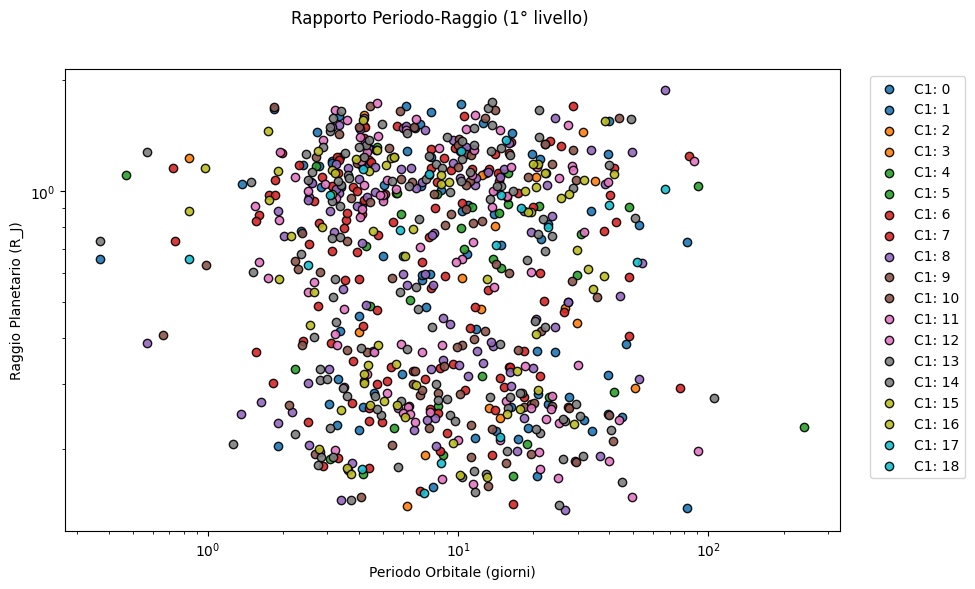

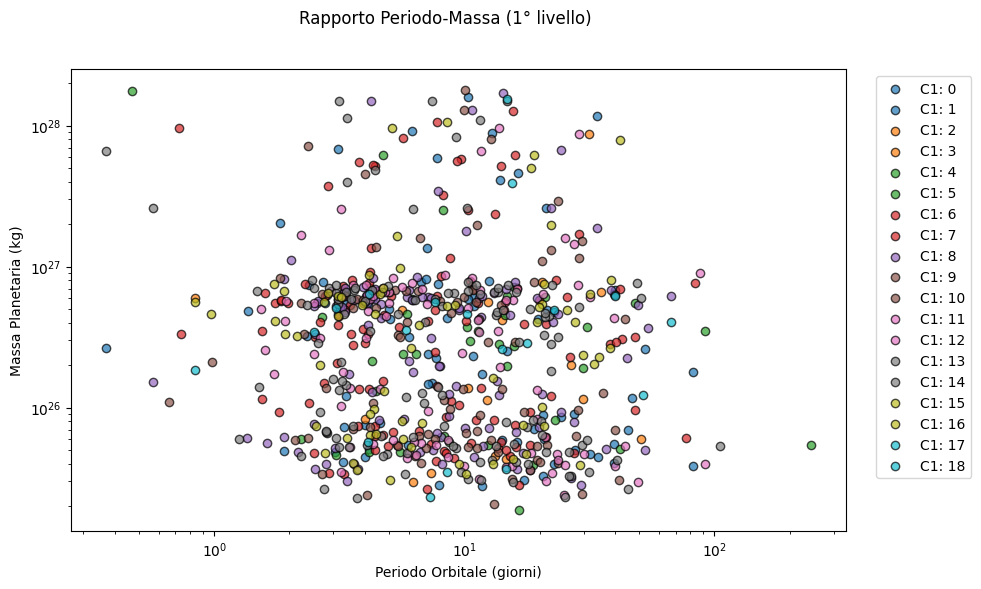

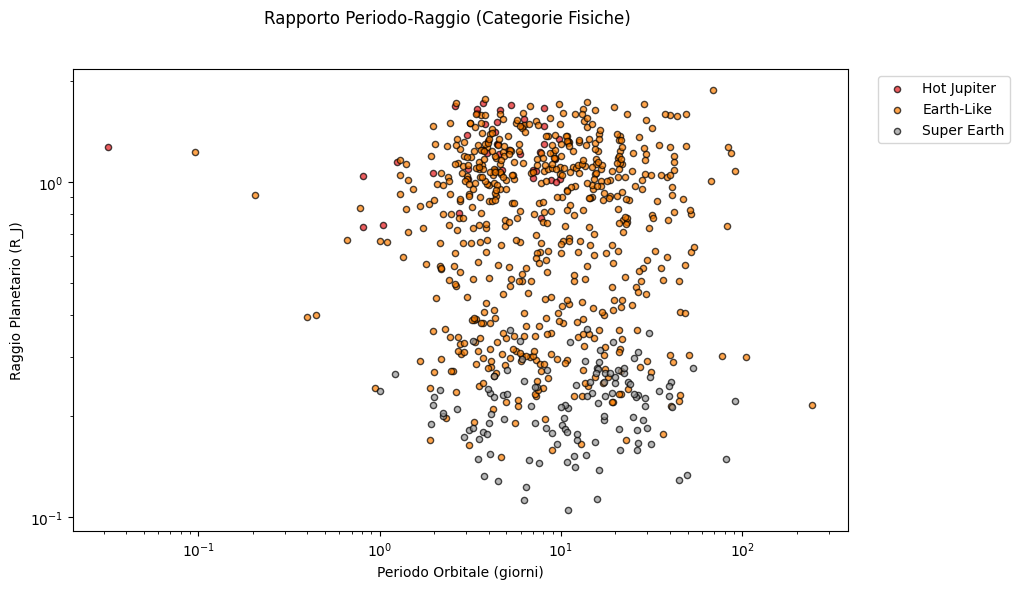

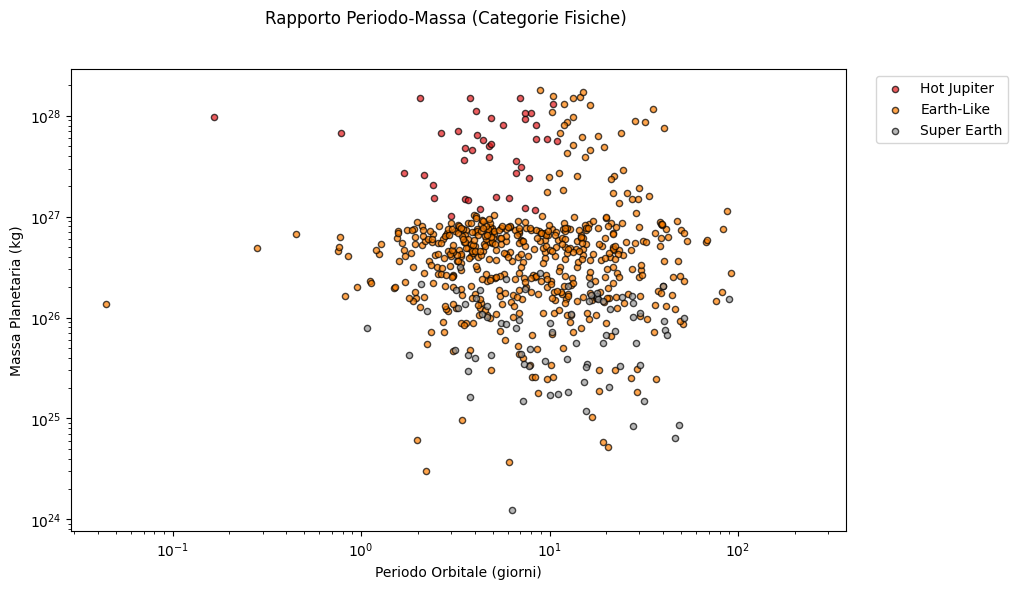

In [105]:
# --- Caricamento e preparazione dei dati ---
auxT_path = './Check_Dataset/TrainingData/AuxillaryTable.csv'
fmParam_path = './Check_Dataset/TrainingData/Ground Truth Package/FM_Parameter_Table.csv'

df_aux = pd.read_csv(auxT_path)
df_fm = pd.read_csv(fmParam_path)
df_merged = pd.merge(df_aux, df_fm, on='planet_ID')
df_merged['planet_ID'] = df_merged['planet_ID'].astype(str)

# Calcola rapporti (usati eventualmente per altri plot)
df_merged['Rapporto_PM'] = df_merged['planet_orbital_period'] / df_merged['planet_mass_kg']
df_merged['Rapporto_PR'] = df_merged['planet_orbital_period'] / df_merged['planet_radius']

# pl_inds e pl_cluster_map devono essere definiti nel tuo ambiente
pl_ind_str = [str(x) for x in pl_inds]
df_merged['cluster_label'] = df_merged['planet_ID'].map(pl_cluster_map)

# Seleziona solo i pianeti presenti in pl_inds e che hanno un cluster assegnato
df_clustered = df_merged[
    df_merged['planet_ID'].isin(pl_ind_str) & df_merged['cluster_label'].notna()
].copy()

df_clustered['cluster_label'] = df_clustered['cluster_label'].astype('category')
df_clustered['cluster_label_code'] = df_clustered['cluster_label'].cat.codes

# Crea la colonna "cluster_livello1" (primo livello, cioè la parte prima del punto)
df_clustered['cluster_livello1'] = df_clustered['cluster_label'].apply(
    lambda x: x.split('.')[0] if isinstance(x, str) else x
).astype('category')

# Ordina i cluster di primo livello in ordine crescente
categories_lvl1 = sorted(
    df_clustered['cluster_livello1'].cat.categories,
    key=lambda x: float(x) if x.isdigit() else x
)
colors_lvl1 = plt.cm.tab10(np.linspace(0, 1, len(categories_lvl1)))

# --- Classificazione fisica dei pianeti ---
def classify_planet(row):
    period = row['planet_orbital_period']
    mass = row['planet_mass_kg']
    radius = row['planet_radius']
    # Soglie esemplificative – adattale in base al dataset
    if period < 10 and mass > 1e27:
        return 'Hot Jupiter'
    elif mass < 5e25:
        return 'Super Earth'
    elif period > 100 and mass > 1e27:
        return 'Cold Jupiter'
    else:
        return 'Earth-Like'

df_clustered['phys_category'] = df_clustered.apply(classify_planet, axis=1)

# Crea una mappa di colori per le categorie fisiche
categories_phys = df_clustered['phys_category'].unique()
colors_phys = plt.cm.Set1(np.linspace(0, 1, len(categories_phys)))
phys_color_map = {cat: colors_phys[i] for i, cat in enumerate(categories_phys)}

# Parametri per ridurre l'overplotting
marker_size = 20
alpha_val = 0.7
jitter_x = 0.05 * df_clustered['planet_orbital_period'].std()
jitter_radius = 0.05 * df_clustered['planet_radius'].std()
jitter_mass = 0.05 * df_clustered['planet_mass_kg'].std()

# --- Grafici basati sul primo livello (cluster_level1) ---

# Plot Rapporto Periodo-Raggio (1° livello)
plt.figure(figsize=(10, 6))
for i, cl in enumerate(categories_lvl1):
    mask = df_clustered['cluster_livello1'] == cl
    if mask.sum() > 0:
        plt.scatter(
            df_clustered.loc[mask, 'planet_orbital_period'],
            df_clustered.loc[mask, 'planet_radius'],
            color=colors_lvl1[i],
            alpha=0.9,
            edgecolors='black',
            label=f'C1: {cl}'
        )
plt.xlabel('Periodo Orbitale (giorni)')
plt.ylabel('Raggio Planetario (R_J)')
plt.legend(bbox_to_anchor=(1.03, 1), loc='upper left')
ax = plt.gca()
y_ticks = ax.get_yticks()
plt.yticks(y_ticks, [f"{tick:.2e}" for tick in y_ticks])
plt.xscale('log')
plt.yscale('log')
PR_name = get_unique_filename('P-R', '.png', 'Clusters/')
plt.suptitle('Rapporto Periodo-Raggio (1° livello)')
plt.savefig(PR_name, bbox_inches='tight')
plt.show()

# Plot Rapporto Periodo-Massa (1° livello)
plt.figure(figsize=(10, 6))
for i, cl in enumerate(categories_lvl1):
    mask = df_clustered['cluster_livello1'] == cl
    if mask.sum() > 0:
        plt.scatter(
            df_clustered.loc[mask, 'planet_orbital_period'],
            df_clustered.loc[mask, 'planet_mass_kg'],
            color=colors_lvl1[i],
            alpha=0.7,
            edgecolors='black',
            label=f'C1: {cl}'
        )
plt.xlabel('Periodo Orbitale (giorni)')
plt.ylabel('Massa Planetaria (kg)')
plt.legend(bbox_to_anchor=(1.03, 1), loc='upper left')
ax = plt.gca()
y_ticks = ax.get_yticks()
plt.yticks(y_ticks, [f"{tick:.2e}" for tick in y_ticks])
plt.xticks(ax.get_xticks())
plt.xscale('log')
plt.yscale('log')
PM_name = get_unique_filename('P-M', '.png', 'Clusters/')
plt.suptitle('Rapporto Periodo-Massa (1° livello)')
plt.savefig(PM_name, bbox_inches='tight')
plt.show()

# --- Grafici basati sulle categorie fisiche con miglioramento della visibilità ---

# Plot Rapporto Periodo-Raggio (Categorie fisiche)
plt.figure(figsize=(10, 6))
# UNJITTERED
'''
for cat, color in phys_color_map.items():
    mask = df_clustered['phys_category'] == cat
    # Rimuovi completamente il jitter
    x = df_clustered.loc[mask, 'planet_orbital_period']
    y = df_clustered.loc[mask, 'planet_radius']
    plt.scatter(
        x, y,
        color=color,
        s=7,
        alpha=0.7,
        edgecolors='black',
        label=cat
    )
'''
# JITTERED
for cat, color in phys_color_map.items():
    mask = df_clustered['phys_category'] == cat
    # Applica jitter alle coordinate per ridurre l'overplotting
    x = df_clustered.loc[mask, 'planet_orbital_period'] + np.random.normal(0, jitter_x, size=mask.sum())
    y = df_clustered.loc[mask, 'planet_radius'] + np.random.normal(0, jitter_radius, size=mask.sum())
    plt.scatter(
        x, y,
        color=color,
        s=marker_size,
        alpha=alpha_val,
        edgecolors='black',
        label=cat
    )
plt.xlabel('Periodo Orbitale (giorni)')
plt.ylabel('Raggio Planetario (R_J)')
plt.legend(bbox_to_anchor=(1.03, 1), loc='upper left')
plt.suptitle('Rapporto Periodo-Raggio (Categorie Fisiche)')
ax = plt.gca()
y_ticks = ax.get_yticks()
plt.yticks(y_ticks, [f"{tick:.2e}" for tick in y_ticks])
plt.xticks(ax.get_xticks())
plt.xscale('log')
plt.yscale('log')
PR_phys_name = get_unique_filename('P-R_phys_log', '.png', 'Clusters/')
plt.savefig(PR_phys_name, bbox_inches='tight')
plt.show()

# Plot Rapporto Periodo-Massa (Categorie fisiche)
plt.figure(figsize=(10, 6))
'''
for cat, color in phys_color_map.items():
    mask = df_clustered['phys_category'] == cat
    # Rimuovi completamente il jitter
    x = df_clustered.loc[mask, 'planet_orbital_period']
    y = df_clustered.loc[mask, 'planet_mass_kg']
    plt.scatter(
        x, y,
        color=color,
        s=7,
        alpha=0.7,
        edgecolors='black',
        label=cat
    )
'''
for cat, color in phys_color_map.items():
    mask = df_clustered['phys_category'] == cat
    # Applica jitter alle coordinate per ridurre l'overplotting
    x = df_clustered.loc[mask, 'planet_orbital_period'] + np.random.normal(0, jitter_x, size=mask.sum())
    y = df_clustered.loc[mask, 'planet_mass_kg'] + np.random.normal(0, jitter_mass, size=mask.sum())
    plt.scatter(
        x, y,
        color=color,
        s=marker_size,
        alpha=alpha_val,
        edgecolors='black',
        label=cat
    )
plt.xlabel('Periodo Orbitale (giorni)')
plt.ylabel('Massa Planetaria (kg)')
plt.legend(bbox_to_anchor=(1.03, 1), loc='upper left')
plt.suptitle('Rapporto Periodo-Massa (Categorie Fisiche)')
ax = plt.gca()
y_ticks = ax.get_yticks()
plt.yticks(y_ticks, [f"{tick:.2e}" for tick in y_ticks])
plt.xticks(ax.get_xticks())
plt.xscale('log')
plt.yscale('log')
PM_phys_name = get_unique_filename('P-M_phys_log', '.png', 'Clusters/')
plt.savefig(PM_phys_name, bbox_inches='tight')
plt.show()

# Salvataggio risultati
### Salviamo i risultati mediante `to_competition_format()`, nel formato richiesto dalla Challenge 

In [106]:
out = to_competition_format(tracedata_arr=all_p, weights_arr=all_w)
#out_name = get_unique_filename('Submission','.hdf5','./output/')
#out_RT = to_regular_track_format(tracedata_arr=all_p, weights_arr=all_w,name=out_name)